# **Data Science Fundación YPF + Ingenias**

### Grupo 10

## **Proyecto** : EDA para el dataset de Energías Renovables en Argentina y su contribución al sistema eléctrico de todo el país.
    
<img src="argentinaER.png">

### **Origen del Dataset**: El dataset se descargó de la página de CAMMESA (Compañía Administradora del Mercado Mayorista Eléctrico Sociedad Anónima) que es la compañía argentina encargada de operar el mercado eléctrico mayorista de Argentina
### Su función es operar el Sistema Argentino de Interconexión, planificar las necesidades de capacidad de energía, coordinar de las operaciones de despacho y regular las transacciones económicas del mercado eléctrico mayorista 

### **Descripción del dataset** : Este dataset contiene la información de la energía generada por fuentes de Energías Renovables y su contribución al sistema eléctrico de Argentina. A su vez contiene la demanda histórica de energía eléctrica desde el año 2011 hasta el año 2023 en el país. 
### La Base de Datos es de paso mensual, desde enero 2011 hasta junio de 2023, conteniendo los siguientes campos con una cantidad total de 15999 registros:

a) Central / máquina por región del país

b) Tipo de fuente de energía renovable (Hidro < 50 MW; Eólico, Solar, Biomasa, Biodiesel)

c)Provincia

d) Mes/Año

e) Energía Generada (GWh)

### **Objetivo del proyecto**: predecir la cantidad de energía que generaran las fuentes de energías renovables en los próximos años(5) y su contribución para satisfacer la demanda de energía eléctrica en el país

## 1. Instalar e importar los paquetes que vamos a necesitar para explorar y modificar los datos

In [1]:
!pip install fuzzywuzzy 
#string matching
!pip install geopandas  
#para trabajar con datos espaciales en python
!pip install contextily 
#para tener mapas base para nuestras geometrias
!pip install seaborn
#visualización estadística

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gdp
from fuzzywuzzy import fuzz, process
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider #Para generar el deslizador
import contextily as ctx #Para armar el mapa base.
from IPython.display import Markdown

C:\Users\eilee\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## 2.Preparación y limpieza de datos

In [3]:
#Leemos el archivo con el data set
er = pd.read_csv('ER_v2.csv')

In [4]:
er.head(10)

,AÑO,CENTRAL,CENTRAL DESCRIPCIÓN,MAQUINA,FUENTE DE ENERGÍA,REGIÓN,PROVINCIA,MES,ENERGÍA GENERADA [GWh],Nueva Generación
0,2011,AESP,AES PARANA,AESPCC01,BIODIESEL,LITORAL,BUENOS AIRES,ene-11,0,Resto
1,2011,AESP,AES PARANA,AESPCC02,BIODIESEL,LITORAL,BUENOS AIRES,ene-11,0,Resto
2,2011,AMEGHI,F. AMEGHINO,AMEGHI,HIDRO <=50MW,PATAGONIA,CHUBUT,ene-11,13.8,Resto
3,2011,ARAUEO,ARAUCO EOLICO,ARAUEO,EOLICO,NOROESTE,LA RIOJA,ene-11,0.1,Resto
4,2011,CACVHI,C.H.CACHEUTA VI,CACVHI,HIDRO <=50MW,CUYO,MENDOZA,ene-11,0,Resto
5,2011,CADIHI,CADILLAL,CADIHI,HIDRO <=50MW,NOROESTE,TUCUMAN,ene-11,0.6,Resto
6,2011,CALEHI,LA CALERA,CALEHI,HIDRO <=50MW,CENTRO,CORDOBA,ene-11,0.9,Resto
7,2011,CARRHI,CH CARRIZAL,CARRHI,HIDRO <=50MW,CUYO,MENDOZA,ene-11,5.4,Resto
8,2011,CASSHI,CASSAFOUSTH,CASSHI,HIDRO <=50MW,CENTRO,CORDOBA,ene-11,4.1,Resto
9,2011,CEJEHI,CRUZ DEL EJE,CEJEHI,HIDRO <=50MW,CENTRO,CORDOBA,ene-11,0,Resto


In [5]:
#Cambiamos el nombre de las columnas para que sea de más fácil manipulación.
er.rename({"AÑO":"anio","CENTRAL":"central",
           "CENTRAL DESCRIPCIÓN":"central_des",
           "MAQUINA":"maquina",
           "FUENTE DE ENERGÍA":"fuente_de",
           "REGIÓN":"region",
           "ENERGÍA GENERADA [GWh]":"energia_gen",
           "Nueva Generación":"nueva_gen",
           "PROVINCIA":"prov",
           "MES":"mes"},
          axis='columns', inplace=True)
er.columns

Index(['anio', 'central', 'central_des', 'maquina', 'fuente_de', 'region',
       'prov', 'mes', 'energia_gen', 'nueva_gen'],
      dtype='object')

In [6]:
er.info() #info sobre cantidad de columnas,registros, y tipo de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15997 entries, 0 to 15996
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   anio         15997 non-null  int64 
 1   central      15997 non-null  object
 2   central_des  15997 non-null  object
 3   maquina      15997 non-null  object
 4   fuente_de    15997 non-null  object
 5   region       15997 non-null  object
 6   prov         15997 non-null  object
 7   mes          15997 non-null  object
 8   energia_gen  15997 non-null  object
 9   nueva_gen    15997 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.2+ MB


In [7]:
#Sacamos las filas correspondientes a la demanda total Demanda MEM
#Primero vemos que filas poseen Demanda MEM
index_mem=er[er["central"]=="Demanda MEM"].index #Indice de las filas que queremos eliminar
er.drop(index_mem,inplace=True) #Eliminamos esas filas

In [8]:
#Cambiamos el tipo de dato de la energía generada de objeto a decimal.
er["energia_gen"]=er["energia_gen"].astype('float64')

In [9]:
missing_values = er.isnull().sum().sort_values(ascending = False) # contabiliza
        # datos faltantes y los ordena de mayor a menor
        # según la columna
missing_values

anio           0
central        0
central_des    0
maquina        0
fuente_de      0
region         0
prov           0
mes            0
energia_gen    0
nueva_gen      0
dtype: int64

In [10]:
'''
Para poder convertir las filas con enero, al estar en español no interpreta bien el formato. Primero debemos pasar ene a jan, 
abr a apr, ago a aug y dic por dec. 
La abrievatura en inglés para que después pueda convertirlo al formato en datetime correspondiente. 
'''
# Reemplazar en la columna 'mes'
er['mes'] = er['mes'].str.replace('ene', 'jan')
er['mes'] = er['mes'].str.replace('abr', 'apr')
er['mes'] = er['mes'].str.replace('ago', 'aug')
er['mes'] = er['mes'].str.replace('dic', 'dec')

In [11]:
#Pasamos la informacion al formato datetime
er['mes']=pd.to_datetime(er['mes'],format='%b-%d').dt.month #Tomamos el mes, que queda representado con un numero. 

er['anio']=pd.to_datetime(er['anio'],format='%Y').dt.year #Tomamos el año

In [12]:
'''
Es de interés conocer la descipción de la energía generada ya que es 
información del tipo punto flotante, las fechas no son de interés para este tipo de descripción. 
'''
er['energia_gen'].describe() #estadística descriptiva

count    15847.000000
mean         5.535458
std         10.300713
min          0.000000
25%          0.000000
50%          1.500000
75%          6.000000
max        167.800000
Name: energia_gen, dtype: float64

## 3.Gráficos para ver como se componen y distribuyen los datos

## **Countplot::**

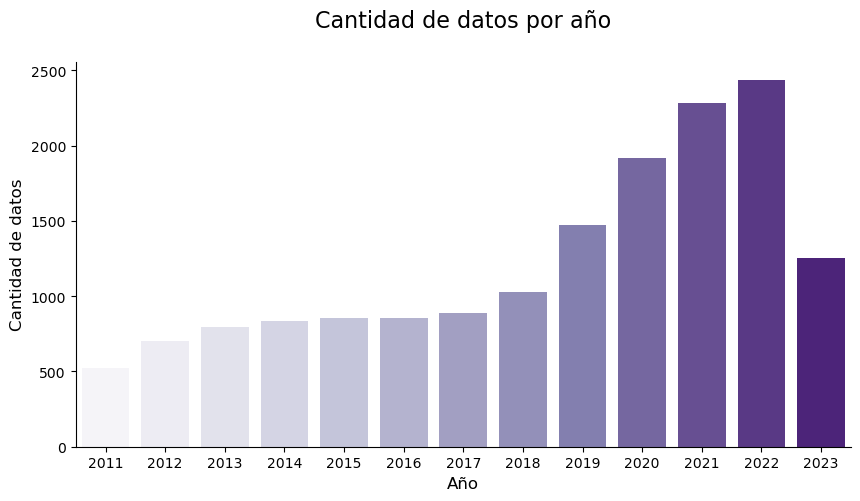

In [13]:
# Contar la cantidad de datos generados por año
plt.figure(figsize=(10,5))
sns.countplot(x="anio", data=er, palette="Purples")
plt.ylabel("Cantidad de datos", size=12)
plt.xlabel("Año", size=12)
plt.title("Cantidad de datos por año", size=16, pad=25)
sns.despine()

## **Barplot**

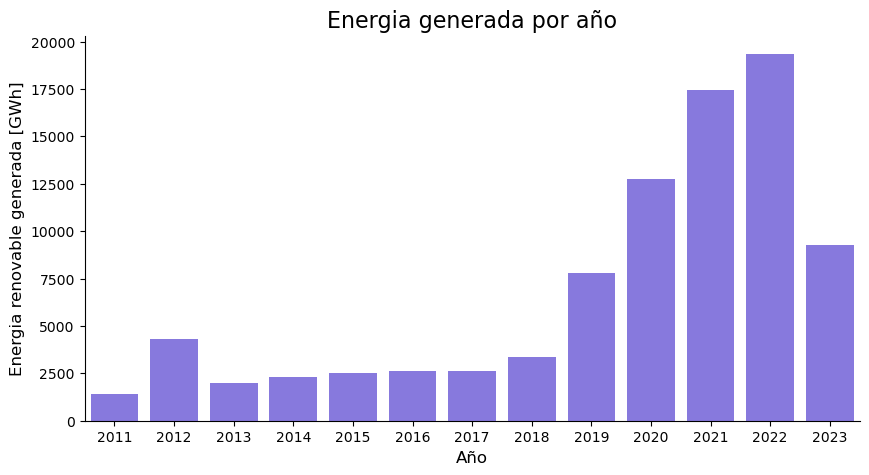

In [14]:
# Cantidad de energía renovable generada por año

# Filtramos los datos y sumamos
total_anio = er.groupby(['anio'])['energia_gen'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x = total_anio.anio ,y = total_anio.energia_gen, color="mediumslateblue")
plt.xlabel("Año", fontsize=12)
plt.ylabel("Energia renovable generada [GWh]", fontsize=12)
plt.title("Energia generada por año", fontsize=16)
sns.despine()

## Gráfico de barras apiladas:

C:\Users\eilee\AppData\Local\Temp\ipykernel_9700\2285254882.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_cat_anio = cat_anio.pivot('anio', 'fuente_de', 'energia_gen').fillna(0).reset_index()


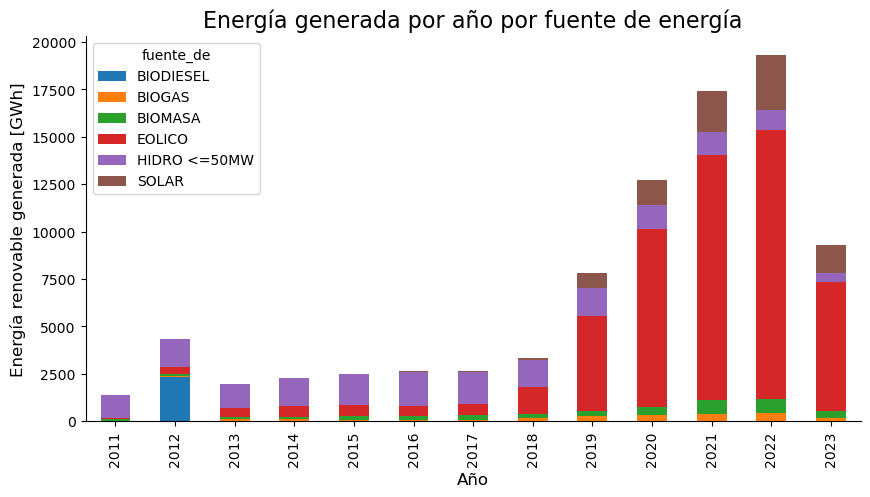

In [15]:
# Cantidad de energía renovable generada por año diferenciada por tipo de fuente de energía

# Filtramos los datos y sumamos
cat_anio = er.groupby(['anio','fuente_de'])[['energia_gen']].sum().reset_index()
df_cat_anio = cat_anio.pivot('anio', 'fuente_de', 'energia_gen').fillna(0).reset_index()

# Gráfico de barras apiladas
df_cat_anio.set_index('anio').plot(kind='bar', stacked=True, figsize=(10,5))
plt.xlabel("Año", fontsize=12)
plt.ylabel("Energía renovable generada [GWh]", fontsize=12)
plt.title("Energía generada por año por fuente de energía", fontsize=16)
sns.despine()

## Gráfico de barras agrupadas por tipo energía y cantidad de máquinas

In [16]:
# Agrupar por las columnas maquina y fuente_de, y contar la cantidad de repeticiones
grouped = er.groupby(['maquina', 'fuente_de']).size().reset_index(name='CANTIDAD')
# Filtrar las filas donde fuente_de no sea igual a "Demanda MEM"
filtered_grouped = grouped[grouped['fuente_de'] != 'Demanda MEM']
# Imprimir el DataFrame resultante
print(filtered_grouped)


      maquina  fuente_de  CANTIDAD
0    ABBGDI01     BIOGAS        28
1        ABEF     BIOGAS         3
2    ABEFDI01     BIOGAS        25
3      ACHIEO     EOLICO        59
4    AESPCC01  BIODIESEL       150
..        ...        ...       ...
223    VSECEO     EOLICO        33
224  VTBGDI01     BIOGAS        34
225  YAN2DI01     BIOGAS        32
226  YANQDI01     BIOGAS        71
227    ZONDFV      SOLAR         3

[228 rows x 3 columns]


In [17]:
# Contar los valores distintos en las columnas maquina y fuente_de
maquina_distinct_count = filtered_grouped['maquina'].nunique()
fuente_energia_distinct_count = filtered_grouped['fuente_de'].nunique()

# Sumar la columna CANTIDAD
suma_cantidad = filtered_grouped['CANTIDAD'].sum()

# Imprimir los resultados
print(f"Número de valores distintos en la columna maquina: {maquina_distinct_count}")
print(f"Número de valores distintos en la columna fuente_de: {fuente_energia_distinct_count}")
print(f"Suma total de la columna CANTIDAD: {suma_cantidad}")

Número de valores distintos en la columna maquina: 228
Número de valores distintos en la columna fuente_de: 6
Suma total de la columna CANTIDAD: 15847


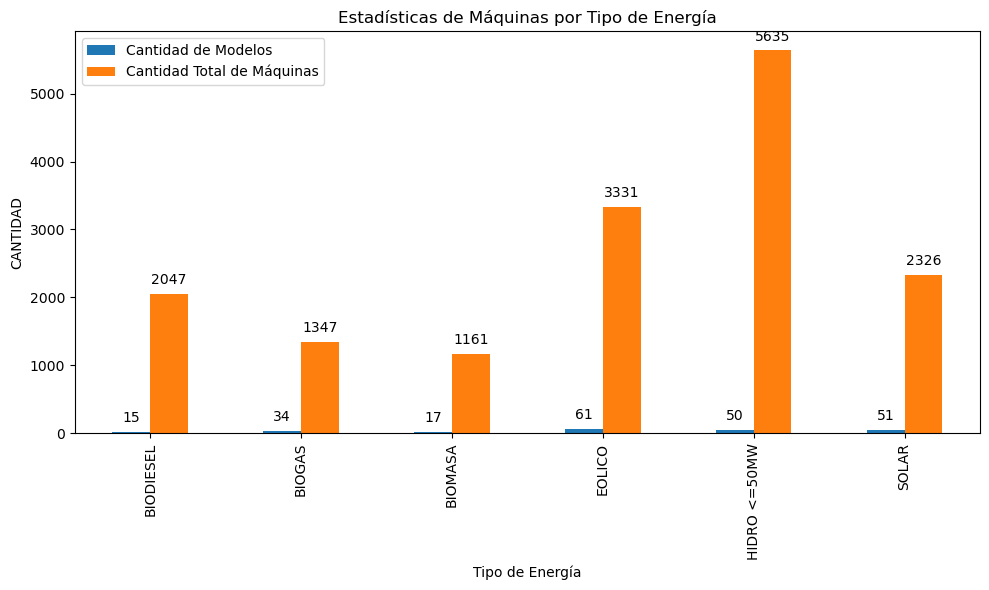

In [18]:

# Agrupar por fuente_de y contar la cantidad de modelos y la cantidad total de maquinas
energy_stats = filtered_grouped.groupby('fuente_de').agg({'maquina': 'count', 'CANTIDAD': 'sum'}).reset_index()

# Renombrar las columnas para mayor claridad
energy_stats.rename(columns={'maquina': 'Cantidad de Modelos', 'CANTIDAD': 'Cantidad Total de Máquinas'}, inplace=True)

# Crear el diagrama de barras agrupadas
fig, ax = plt.subplots(figsize=(10, 6))
energy_stats.plot(kind='bar', x='fuente_de', ax=ax)
ax.set_title('Estadísticas de Máquinas por Tipo de Energía')
ax.set_xlabel('Tipo de Energía')
ax.set_ylabel('CANTIDAD')
ax.legend(["Cantidad de Modelos", "Cantidad Total de Máquinas"])

# Agregar etiquetas con los valores en las barras
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

## Gráfico de barras agrupadas por tipo de energía y fecha

In [19]:

# Seleccionar las columnas deseadas
columnas_deseadas = ['maquina', 'fuente_de', 'anio', 'mes']

# Agrupar por las columnas seleccionadas y contar la cantidad
grupo_df = er.groupby(columnas_deseadas).size().reset_index(name='CANTIDAD')

# Filtrar y eliminar filas donde fuente_de es igual a "Demanda MEM"
grupo_df_filtrado = grupo_df[grupo_df['fuente_de'] != 'Demanda MEM']

# Mostrar el DataFrame filtrado
print(grupo_df_filtrado)

        maquina fuente_de  anio  mes  CANTIDAD
0      ABBGDI01    BIOGAS  2021    3         1
1      ABBGDI01    BIOGAS  2021    4         1
2      ABBGDI01    BIOGAS  2021    5         1
3      ABBGDI01    BIOGAS  2021    6         1
4      ABBGDI01    BIOGAS  2021    7         1
...         ...       ...   ...  ...       ...
15817  YANQDI01    BIOGAS  2023    5         1
15818  YANQDI01    BIOGAS  2023    6         1
15819    ZONDFV     SOLAR  2023    4         1
15820    ZONDFV     SOLAR  2023    5         1
15821    ZONDFV     SOLAR  2023    6         1

[15822 rows x 5 columns]


In [20]:
!pip install matplotlib mplcursors ipywidgets

<IPython.core.display.Javascript object>


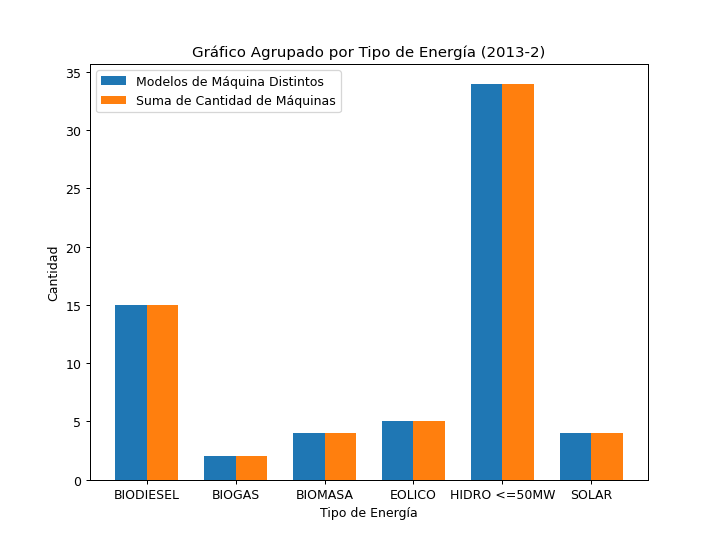

SelectionSlider(continuous_update=False, description='Fecha:', options=('2011-1', '2011-10', '2011-11', '2011-…

Output()

In [21]:
# Crear una figura interactiva
%matplotlib notebook
%matplotlib widget

import ipywidgets as widgets
from IPython.display import display, clear_output

# Crear una nueva columna de fecha combinando anio y mes
grupo_df_filtrado['FECHA'] = grupo_df_filtrado['anio'].astype(str) + '-' + grupo_df_filtrado['mes'].astype(str)

# Crear la figura y el eje
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Función para crear y mostrar el gráfico interactivo
def create_interactive_chart(date):
    # Limpiar el eje antes de crear el nuevo gráfico
    ax.clear()
    
    # Filtrar los datos por la fecha seleccionada
    df_date = grupo_df_filtrado[grupo_df_filtrado['FECHA'] == date]
    
    # Agrupar y calcular la cantidad de modelos y la suma de la cantidad de máquinas por tipo de energía
    grouped = df_date.groupby(['fuente_de']).agg({'maquina': 'nunique', 'CANTIDAD': 'sum'}).reset_index()
    
    # Crear un gráfico de barras una al lado de la otra
    width = 0.35
    x = range(len(grouped))
    
    bars1 = ax.bar(x, grouped['maquina'], width, label='Modelos de Máquina Distintos')
    bars2 = ax.bar([i + width for i in x], grouped['CANTIDAD'], width, label='Suma de Cantidad de Máquinas')
    
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(grouped['fuente_de'])
    ax.legend()
    
    ax.set_xlabel('Tipo de Energía')
    ax.set_ylabel('Cantidad')
    ax.set_title(f'Gráfico Agrupado por Tipo de Energía ({date})')
    
    fig.canvas.draw()

# Obtener la lista de fechas únicas
unique_dates = sorted(grupo_df_filtrado['FECHA'].unique())

# Crear un slider interactivo para seleccionar la fecha
date_slider = widgets.SelectionSlider(options=unique_dates, description='Fecha:', continuous_update=False)
out = widgets.Output()

# Mostrar el gráfico y el slider
widgets.interactive_output(create_interactive_chart, {'date': date_slider})
display(date_slider, out)

plt.show()


## 4. Decidimos visualizar la cantidad de energía generada por provincia

In [22]:
'''
Para esto se bajo un archivo con datos geopespaciales de Argentina para añadirlo a nuestro dataframe original.
Leemos el archivo shape que tiene los polígonos de las provincias.
Esta información se descargó de la página del Instituto Geográfico Nacional.

'''
prov=gdp.read_file('arg.shp')
prov.head(10)
'''
La columna fna contiene el nombre de las provincias argentinas. 
La columna geometry contiene los polígonos a graficar de cada provincia
'''

'\nLa columna fna contiene el nombre de las provincias argentinas. \nLa columna geometry contiene los polígonos a graficar de cada provincia\n'

In [23]:
n_prov=len(prov['fna'])
print("Hay {} provincias y la Ciudad Autónoma de Buenos Aires".format(n_prov-1))

Hay 23 provincias y la Ciudad Autónoma de Buenos Aires


## **Mapa de energía generada por año por cada provincia**


In [24]:
df=er.copy()
df.drop(['mes'], axis=1,inplace=True) #Eliminamos la columna del mes que no es de interés
df=df.groupby(['prov','anio']).sum('energia_gen').reset_index()

In [32]:
'''
Vamos a observar si tenemos la misma cantidad de provincias en ambos data frame
'''
display(Markdown('**Número de provincias del dataframe original:**'),len(df['prov'].unique()))
print(df['prov'].unique())
display(Markdown('**Número de provincias del shape:**'),len(prov['fna'].unique()))
print(prov['fna'].unique())

**Número de provincias del dataframe original:**

20

['BUENOS AIRES' 'CATAMARCA' 'CHACO' 'CHUBUT' 'CORDOBA' 'CORRIENTES'
 'JUJUY' 'LA PAMPA' 'LA RIOJA' 'MENDOZA' 'MISIONES' 'NEUQUÉN' 'RIO NEGRO'
 'SALTA' 'SAN JUAN' 'SAN LUIS' 'SANTA CRUZ' 'SANTA FE'
 'SANTIAGO DEL ESTERO' 'TUCUMAN']


**Número de provincias del shape:**

24

['Ciudad Autónoma de Buenos Aires' 'Provincia del Neuquén'
 'Provincia de San Luis' 'Provincia de Santa Fe' 'Provincia del Chubut'
 'Provincia de Mendoza' 'Provincia de Entre Ríos' 'Provincia de San Juan'
 'Provincia de Jujuy' 'Provincia de Santiago del Estero'
 'Provincia de Río Negro' 'Provincia de Corrientes'
 'Provincia de Misiones' 'Provincia de Salta' 'Provincia de Córdoba'
 'Provincia de Buenos Aires' 'Provincia de La Pampa'
 'Provincia de La Rioja' 'Provincia de Catamarca' 'Provincia de Tucumán'
 'Provincia del Chaco' 'Provincia de Formosa' 'Provincia de Santa Cruz'
 'Provincia Tierra del Fuego']


In [25]:
'''
Vemos que faltan provincias. Agregamos a Tierra del Fuego, Entre Rios y Formosa, para que la grafique.
'''
df = pd.concat([df, pd.DataFrame([('TIERRA DEL FUEGO', 2011,0)],columns=df.columns)],
    ignore_index=True)
df = pd.concat([df, pd.DataFrame([('ENTRE RIOS', 2011,0)],columns=df.columns)],
    ignore_index=True)
df = pd.concat([df, pd.DataFrame([('FORMOSA', 2011,0)],columns=df.columns)],
    ignore_index=True)

# Crear un rango de años únicos y provincias únicas
anios_unicos = range(df["anio"].min(), df["anio"].max() + 1)
provincias_unicas = df["prov"].unique()

# Crear todas las combinaciones posibles de año y provincia
combinaciones = [(anio, provincia) for anio in anios_unicos for provincia in provincias_unicas]

# Crear un nuevo GeoDataFrame con todas las combinaciones
nuevo_gdf = pd.DataFrame(combinaciones, columns=["anio", "prov"])

# Hacer un merge con el GeoDataFrame original para obtener los valores de energía generada
nuevo_gdf = nuevo_gdf.merge(df, on=["anio", "prov"], how="left").fillna(0)

# Renombrar la columna de energía generada
nuevo_gdf = nuevo_gdf.rename(columns={"energia_generada": "energia_generada_nueva"})

In [26]:
#Debemos unir los nombres de las provincias del dataframe er con prov.
#Para ello, como no se escriben de igual manera, utilizamos una coincidencia aproximada de cadenas de caracteres y nos quedamos con la coincidencia más alta.
lista_prov=list(prov['fna']) #Tranformamos en lista los nombres de las provincias.

#Eliminamos la Ciudad Autónoma de Buenos Aires ya que no la tenemos en el dataframe inicial er.
lista_prov.pop(0)

#Definimos una función que busca la coincidencia.
def match_regions(list1, list2):
    # Toma solo la mejor coincidencia
    matched = [process.extract(list1[i], list2, limit=1, scorer=fuzz.partial_ratio)[0][0] for i in range(0,len(list1))]

    return {key: value for (key, value) in zip(list1, matched)}

match_dict = match_regions(list(nuevo_gdf['prov']), lista_prov)
print(match_dict)

#Cambiamos el indice del dataframe para que coincida con el shape
#.map lo que hace es mapear el indice segun una función de entrada, en este caso, el diccionario que creamos.
nuevo_gdf['prov']=nuevo_gdf['prov'].map(match_dict)

#Combinamos el .shape y el dataframe en función de las provincias.
mer=prov.merge(nuevo_gdf,left_on='fna', right_on='prov',how='left')
#Eliminamos la primera fila que corresponde a la Ciudad Autónoma de Buenos Aires.
mer=mer.drop(0)

'''
Las columnas del merge gid, entidad, in1, fdc, sag, fdc2 no son de interés.
Las eliminamos con el método drop
'''
mer.drop(['entidad','gid','in1','fdc','sag','fdc2'], axis=1,inplace=True)
mer=mer.dropna()

{'BUENOS AIRES': 'Provincia de Buenos Aires', 'CATAMARCA': 'Provincia de Catamarca', 'CHACO': 'Provincia del Chaco', 'CHUBUT': 'Provincia del Chubut', 'CORDOBA': 'Provincia de Córdoba', 'CORRIENTES': 'Provincia de Corrientes', 'JUJUY': 'Provincia de Jujuy', 'LA PAMPA': 'Provincia de La Pampa', 'LA RIOJA': 'Provincia de La Rioja', 'MENDOZA': 'Provincia de Mendoza', 'MISIONES': 'Provincia de Misiones', 'NEUQUÉN': 'Provincia del Neuquén', 'RIO NEGRO': 'Provincia de Río Negro', 'SALTA': 'Provincia de Salta', 'SAN JUAN': 'Provincia de San Juan', 'SAN LUIS': 'Provincia de San Luis', 'SANTA CRUZ': 'Provincia de Santa Cruz', 'SANTA FE': 'Provincia de Santa Fe', 'SANTIAGO DEL ESTERO': 'Provincia de Santiago del Estero', 'TUCUMAN': 'Provincia de Tucumán', 'TIERRA DEL FUEGO': 'Provincia Tierra del Fuego', 'ENTRE RIOS': 'Provincia de Entre Ríos', 'FORMOSA': 'Provincia de Formosa'}


In [27]:
def update_map(year):
    ax.clear()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Filtra el GeoDataFrame por el año seleccionado
    filtered_gdf = mer[mer['anio'] == year]

    # Plotea el mapa
    im=filtered_gdf.plot(column='energia_gen', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax,alpha=0.8)
    ax.set_title(f'Energía Generada (GWh) por Provincia - Año {int(year)}')

    # Agregar un mapa base
    ctx.add_basemap(ax, crs=mer.crs.to_string())

   # Elimina el colorbar anterior y crea uno nuevo
    if hasattr(ax, 'cax'):
        ax.cax.remove()  # Elimina la colorbar anterior
    cbar = fig.colorbar(im.get_children()[0], cax=cax)
    cbar.set_label('Energía Generada (MWh)')
    ax.cax = cbar.ax

    # Actualiza la visualización
    plt.draw()

<IPython.core.display.Javascript object>


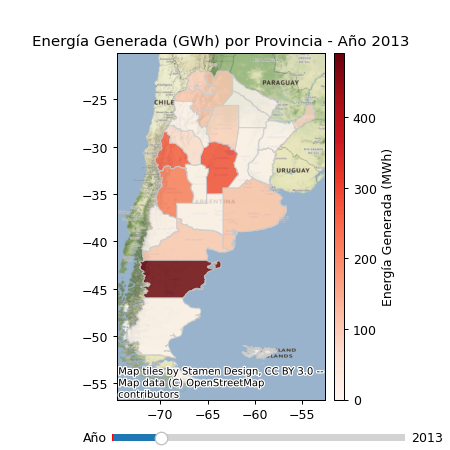

In [28]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
update_map(mer['anio'].min())  # Mostrar el mapa para el año mínimo inicialmente

# Agregar un slider
axcolor = 'lightgoldenrodyellow'
ax_slider = plt.axes([0.25, 0.01, 0.65, 0.03], facecolor=axcolor)
slider = Slider(ax_slider, 'Año', mer['anio'].min(), mer['anio'].max(), valinit=mer['anio'].min(), valstep=1)

# Función de actualización para el slider
def slider_update(val):
    update_map(slider.val)

slider.on_changed(slider_update)

plt.show()

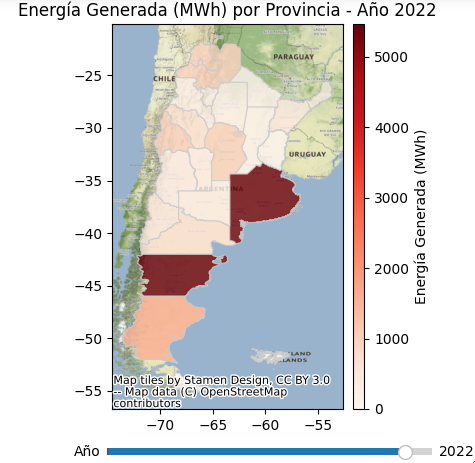